In [1]:
!pip install python-igraph
!pip install cairocffi
!pip install powerlaw
!pip install geopandas

     |████████████████████████████████| 3.2 MB 13.9 MB/s 
     |████████████████████████████████| 70 kB 4.9 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-py3-none-any.whl size=89562 sha256=31d0fee8b5c4df9ba7e7b65feee6cb44532ae742d11a80da9c4839200166d7aa
  Stored in directory: /root/.cache/pip/wheels/e2/ca/86/9db2824f203afe4bdf5aa6ead017f352fcc90e92f095b78871
Successfully built cairocffi
     |████████████████████████████████| 994 kB 13.6 MB/s 
     |████████████████████████████████| 6.3 MB 43.6 MB/s 
     |████████████████████████████████| 15.4 MB 41 kB/s 


In [2]:
import igraph as ig
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import numpy as np
import time
import powerlaw
from pathlib import Path
from shapely.geometry import Point
import geopandas as gpd
import random

from collections import defaultdict

In [3]:
estaciones = "/content/drive/My Drive/Maestria Ciencia de datos - Guillermo Pereira/Datos climatologicos equipo Argentina/datos estaciones/estaciones_all.csv"

In [4]:
from google.colab import files
uploaded = files.upload()

Saving estaciones_all.csv to estaciones_all.csv


In [5]:
import io
estaciones = pd.read_csv(io.BytesIO(uploaded['estaciones_all.csv']) , dtype={'Longitud':np.float64,'Latitud':np.float64,'Altura':np.int64,'Estacion':str})
estaciones = estaciones.sort_values(by='Estacion')
distancias_estaciones = estaciones.copy()

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1,lat1,lon2,lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in km. Use 3956 for miles
    return c * r

In [ ]:
# pd.Series(haversine(estaciones['Longitud'][0],estaciones['Latitud'][0],estaciones['Longitud'][1],estaciones['Latitud'][1]))

0    352.125737
dtype: float64

In [7]:
estaciones

,Longitud,Latitud,Altura,Estacion
46,-60.88,-35.44,76,9 de julio
69,-58.41,-34.56,6,Aeroparque aero
29,-63.98,-36.50,165,Anguil
37,-62.15,-38.72,83,Bahia blanca aero
70,-58.30,-37.75,130,Balcarce
...,...,...,...,...
55,-60.33,-38.39,115,Tres arroyos
47,-60.88,-33.02,50,Unr-zavalla
21,-65.15,-31.95,569,Villa dolores aero
17,-65.48,-33.72,515,Villa mercedes


In [8]:
sensores = np.arange(len(estaciones['Longitud']))
haver = pd.Series(np.arange(len(estaciones['Estacion'])))
dist_estaciones = pd.DataFrame()

for i in sensores:

  for j in sensores: # columns
    lon1 = estaciones['Longitud'][j]
    lat1 = estaciones['Latitud'][j]
    lon2 = estaciones['Longitud'][i]
    lat2 = estaciones['Latitud'][i]

    haver[j] = haversine(lon1,lat1,lon2,lat2)
    
  dist_estaciones[i] = haver

In [9]:
dist_estaciones # matriz de adyacencia

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
0,0,352,217,928,828,790,783,756,746,792,738,1047,799,658,567,618,1194,506,917,712,497,435,942,1036,581,629,376,353,350,606,316,305,520,365,704,858,662,777,177,175,...,121,530,302,400,134,83,30,121,794,231,8,553,727,720,307,305,218,611,510,516,410,518,343,222,377,359,360,687,665,383,247,425,560,326,727,487,402,663,678,900
1,352,0,237,997,965,961,956,920,968,890,968,971,1116,960,723,946,1545,634,1268,1058,624,670,1294,1387,930,552,543,633,625,524,583,566,478,433,531,636,472,552,386,384,...,466,866,206,221,269,304,378,270,1116,188,355,876,446,436,610,608,138,297,797,799,687,795,8,177,25,17,24,351,934,607,372,82,209,491,382,149,564,842,832,1065
2,217,237,0,1086,1012,985,978,948,954,960,948,1137,1014,875,752,830,1358,678,1098,911,668,642,1116,1192,776,709,557,568,564,681,528,515,612,500,731,857,677,773,356,354,...,335,655,331,402,244,234,247,232,893,260,215,656,680,670,389,387,181,534,565,566,454,561,230,63,258,234,230,585,698,370,136,279,429,255,609,325,331,611,606,839
3,928,997,1086,0,199,295,303,285,447,146,471,406,848,726,385,846,1537,423,1246,1017,432,567,1307,1461,992,492,555,680,672,516,676,674,526,587,641,751,684,750,751,754,...,885,1230,794,787,844,867,913,857,1476,842,936,1291,883,887,1161,1161,927,945,1338,1348,1273,1358,994,1044,1006,1014,1021,1037,1493,1291,1170,1062,1071,1255,1103,1117,1329,1571,1595,1802
4,828,965,1012,199,0,96,104,94,248,116,272,587,649,531,261,655,1338,336,1049,823,346,420,1110,1265,807,542,455,533,527,559,540,543,536,533,715,854,745,835,658,661,...,764,1064,759,777,768,780,808,779,1300,791,835,1128,944,946,1026,1025,872,975,1189,1200,1135,1211,960,978,979,983,989,1073,1340,1167,1076,1039,1076,1148,1139,1100,1217,1441,1471,1667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,487,149,325,1117,1100,1101,1097,1059,1114,1018,1115,1047,1264,1109,864,1092,1673,773,1403,1198,763,819,1426,1511,1068,649,689,782,774,621,732,715,591,572,589,658,528,579,535,533,...,605,979,344,329,417,449,515,417,1218,336,489,982,442,431,715,712,284,282,887,887,776,881,156,280,128,135,131,291,1011,682,446,67,124,557,297,0,620,884,864,1093
79,402,564,331,1329,1217,1168,1160,1137,1097,1190,1085,1439,1031,932,958,843,1193,906,983,860,897,803,982,1019,729,1013,774,699,701,988,680,675,909,766,1056,1187,1004,1103,580,577,...,453,481,646,728,512,474,415,497,650,570,394,450,1010,1001,253,251,504,861,311,306,221,294,559,394,584,559,554,902,401,102,196,591,739,79,917,620,0,280,282,512
80,663,842,611,1571,1441,1381,1372,1355,1290,1428,1274,1709,1144,1080,1190,969,1135,1149,990,934,1141,1021,971,963,821,1287,1017,909,914,1262,901,900,1180,1029,1336,1468,1285,1384,836,834,...,685,508,925,1008,783,741,670,769,549,848,655,447,1288,1278,415,416,784,1137,304,292,312,275,837,674,860,835,830,1172,259,281,477,862,1006,359,1181,884,280,0,60,236
81,678,832,606,1595,1471,1414,1406,1387,1328,1454,1313,1721,1194,1126,1217,1017,1196,1173,1049,988,1164,1052,1031,1024,873,1295,1040,941,945,1270,930,928,1190,1044,1336,1463,1284,1379,854,851,...,710,563,928,1008,793,753,688,779,610,852,670,503,1278,1268,450,450,783,1124,357,346,353,329,827,669,849,824,818,1154,320,304,475,846,987,362,1160,864,282,60,0,233


In [10]:
b = dist_estaciones.stack().reset_index()
b.iloc[:,2].describe()

count    6889.000000
mean      702.611700
std       367.738138
min         0.000000
25%       428.000000
50%       671.000000
75%       958.000000
max      1946.000000
Name: 0, dtype: float64

In [112]:
threshold = dist_estaciones[(dist_estaciones > 0) & (dist_estaciones <= 428)].fillna(0)
A = threshold.values

# Create graph, A.astype(bool).tolist() or (A / A).tolist() can also be used.
g = ig.Graph.Adjacency(A.astype(bool).tolist() , mode = 'undirected')

weights = threshold

# Add edge weights and node labels.
# g.es['weight'] = weights
g.vs['label'] = estaciones['Estacion']  # or a.index/a.columns
g.vs['rain'] = -99        # placeholder
g.vs['temp_min'] = -99    # placeholder
g.vs['temp_max'] = -99    # placeholder

In [113]:
ig.summary(g)

IGRAPH U--- 83 825 -- 
+ attr: label (v), rain (v), temp_max (v), temp_min (v)


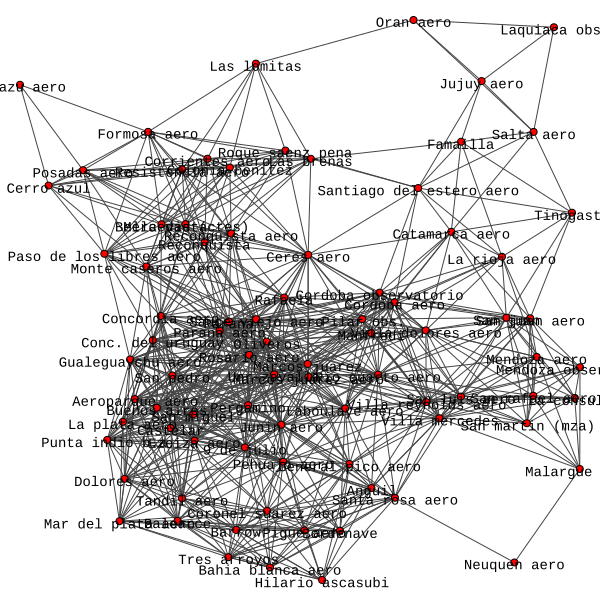

In [114]:
random.seed(1234)
visual_style = dict()
visual_style["layout"] = g.layout_kamada_kawai()
visual_style["bbox"] = (600,600)
visual_style["vertex_size"] = 7
#visual_style["edge_width"] = threshold
ig.plot(g, **visual_style)

In [116]:
ig.write(g, "argentina_clima.graphml", "graphml")

# New Section

In [16]:
uploaded = files.upload()

Saving 9 de julio.txt to 9 de julio.txt
Saving aeroparque.txt to aeroparque.txt
Saving anguil.txt to anguil (1).txt
Saving bahia blanca.txt to bahia blanca.txt
Saving balcarce.txt to balcarce (1).txt
Saving barrow.txt to barrow (1).txt
Saving bella vista.txt to bella vista (1).txt
Saving bordenave.txt to bordenave (1).txt
Saving buenos aires.txt to buenos aires.txt
Saving castelar.txt to castelar (1).txt
Saving catamarca aero.txt to catamarca aero.txt
Saving ceres aero.txt to ceres aero.txt
Saving cerro azul.txt to cerro azul (1).txt
Saving colonia benitez.txt to colonia benitez (1).txt
Saving concepcion.txt to concepcion.txt
Saving concordia.txt to concordia.txt
Saving cordoba aero.txt to cordoba aero.txt
Saving cordoba obs.txt to cordoba obs.txt
Saving coronel suarez.txt to coronel suarez.txt
Saving corrientes.txt to corrientes.txt
Saving dolores.txt to dolores.txt
Saving ezeiza.txt to ezeiza.txt
Saving famailla.txt to famailla.txt
Saving formosa.txt to formosa.txt
Saving gral pico.t

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import os
names_estaciones = os.listdir("/content/drive/My Drive/Maestria Ciencia de datos - Guillermo Pereira/Datos climatologicos equipo Argentina/datos estaciones/ESTACIONES")

In [36]:

datos_completos

,year,month,day,rain,temp_max,temp_min


In [81]:
datos_completos = pd.DataFrame(columns=['year','month','day','rain','temp_max','temp_min','sensor'])

for i in np.arange(len(names_estaciones)):
  try:
    sensor = pd.read_csv(names_estaciones[i],sep='\t',header=None,names=['year','month','day','rain','temp_max','temp_min'])
    sensor['sensor'] = names_estaciones[i]
    datos_completos = datos_completos.append(sensor)

  except:
    pass

In [84]:
datos_completos['sensor'].unique()

array(['anguil.txt', 'balcarce.txt', 'barrow.txt', 'bordenave.txt',
       'cerro azul.txt', 'colonia benitez.txt', 'concepcion.txt',
       'famailla.txt', 'hilario.txt', 'la consulta.txt', 'manfredi.txt',
       'marcos juarez.txt', 'mercedes.txt', 'oliveros.txt', 'parana.txt',
       'pergamino.txt', 'rafaela.txt', 'reconquista.txt', 'san juan.txt',
       'san pedro.txt', 'villa mercedes.txt', 'zavalla.txt',
       'Oran Aero.txt', 'jujuy aero.txt', 'salta aero.txt',
       'las lomitas.txt', 'iguazu.txt', 'santiago del estero.txt',
       'resistencia.txt', 'formosa.txt', 'corrientes.txt', 'posadas.txt',
       'tinogasta.txt', 'la rioja aero.txt', 'catamarca aero.txt',
       'ceres aero.txt', 'reconquista aero.txt', 'paso de los libres.txt',
       'villa dolores.txt', 'cordoba aero.txt', 'pilar aero.txt',
       'sauce viejo.txt', 'parana aero.txt', 'monte caseros.txt',
       'concordia.txt', 'san martin.txt', 'mendoza aero.txt',
       'mendoza obs.txt', 'san luis.txt', 'vill

In [100]:
single_data_point['sensor'][0]

0.0             jujuy aero.txt
0.0             salta aero.txt
0.0            las lomitas.txt
0.0                 iguazu.txt
0.0    santiago del estero.txt
0.0            resistencia.txt
0.0                formosa.txt
0.0             corrientes.txt
0.0                posadas.txt
0.0              tinogasta.txt
0.0          la rioja aero.txt
0.0             ceres aero.txt
0.0       reconquista aero.txt
0.0          villa dolores.txt
0.0           cordoba aero.txt
0.0             pilar aero.txt
0.0            sauce viejo.txt
0.0            parana aero.txt
0.0          monte caseros.txt
0.0              concordia.txt
0.0             san martin.txt
0.0           mendoza aero.txt
0.0            mendoza obs.txt
0.0               san luis.txt
0.0         villa reynolds.txt
0.0             rio cuarto.txt
0.0           gualeguaychu.txt
0.0               malargue.txt
0.0             san rafael.txt
0.0              gral pico.txt
0.0              laboulaye.txt
0.0                pehuajo.txt
0.0     

In [107]:
single_data_point = datos_completos[(datos_completos['year'] == 1970) & (datos_completos['month'] == 1) & (datos_completos['day'] == 1)]

In [108]:
single_data_point

,year,month,day,rain,temp_max,temp_min,sensor
0.0,1970,1,1,0.0,35.0,19.3,jujuy aero.txt
0.0,1970,1,1,0.0,30.8,16.4,salta aero.txt
0.0,1970,1,1,0.0,39.4,21.1,las lomitas.txt
0.0,1970,1,1,10.0,28.3,18.6,iguazu.txt
0.0,1970,1,1,0.0,39.4,21.4,santiago del estero.txt
0.0,1970,1,1,0.0,35.4,20.2,resistencia.txt
0.0,1970,1,1,0.0,35.1,21.7,formosa.txt
0.0,1970,1,1,0.0,34.5,20.3,corrientes.txt
0.0,1970,1,1,12.4,29.1,20.6,posadas.txt
0.0,1970,1,1,0.0,35.5,17.4,tinogasta.txt


In [109]:
g.vs["rain"] = single_data_point['rain']

KeyError: ignored

In [ ]:
ig.write(g, "argentina_clima.graphml", "graphml")